## Project Goals
Current task is to create the most effective regression model to predict churn and find which factors are most associated with churn. 

## Walk though
Initial stages begin with importing, preparing, and exploring data. 
Middle statges consist of indepth feature enginnering.
Final stages will consist of the creation of a model and presentiations for model, and summation. 

Currently hypothosis is: low tenure leads to churn.


In [2]:
from acquire import get_telco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression, LassoCV
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import matplotlib
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from pydataset import data
import statsmodels.api as sm
import re
import multiprocessing as mp


In [3]:
df = get_telco()

In [364]:
import pandas_profiling

In [105]:
pandas_profiling.ProfileReport(df)

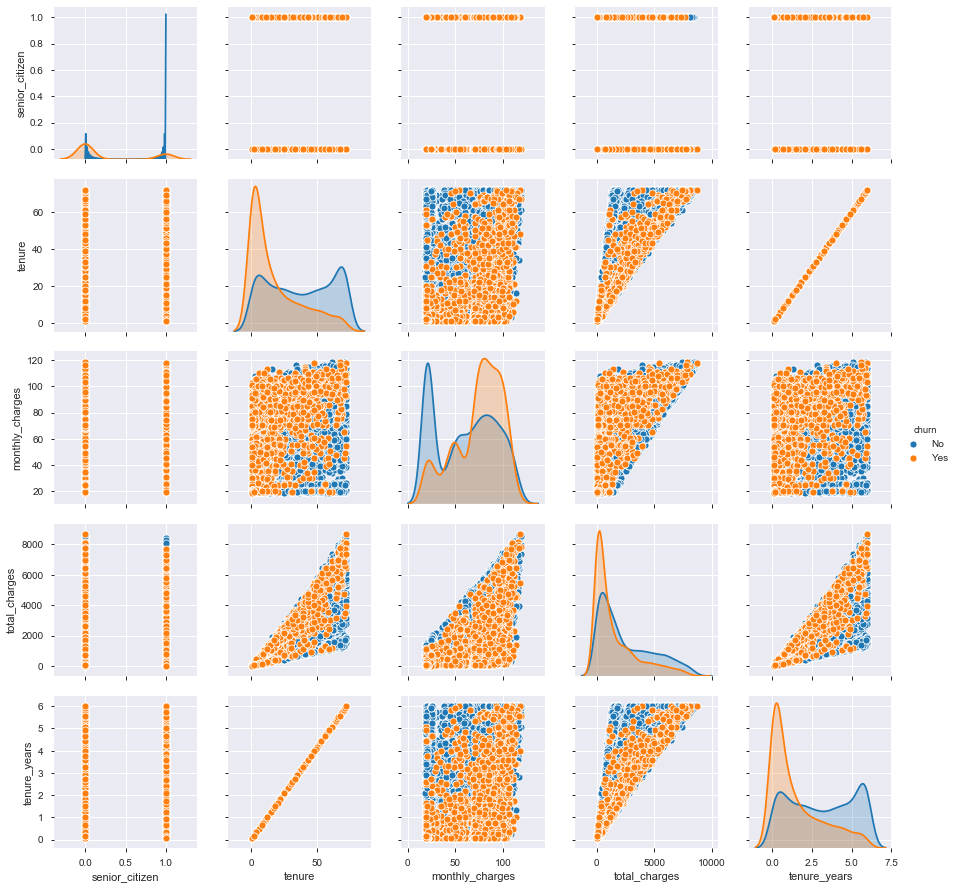

In [106]:
sns.pairplot(data=df, hue="churn")

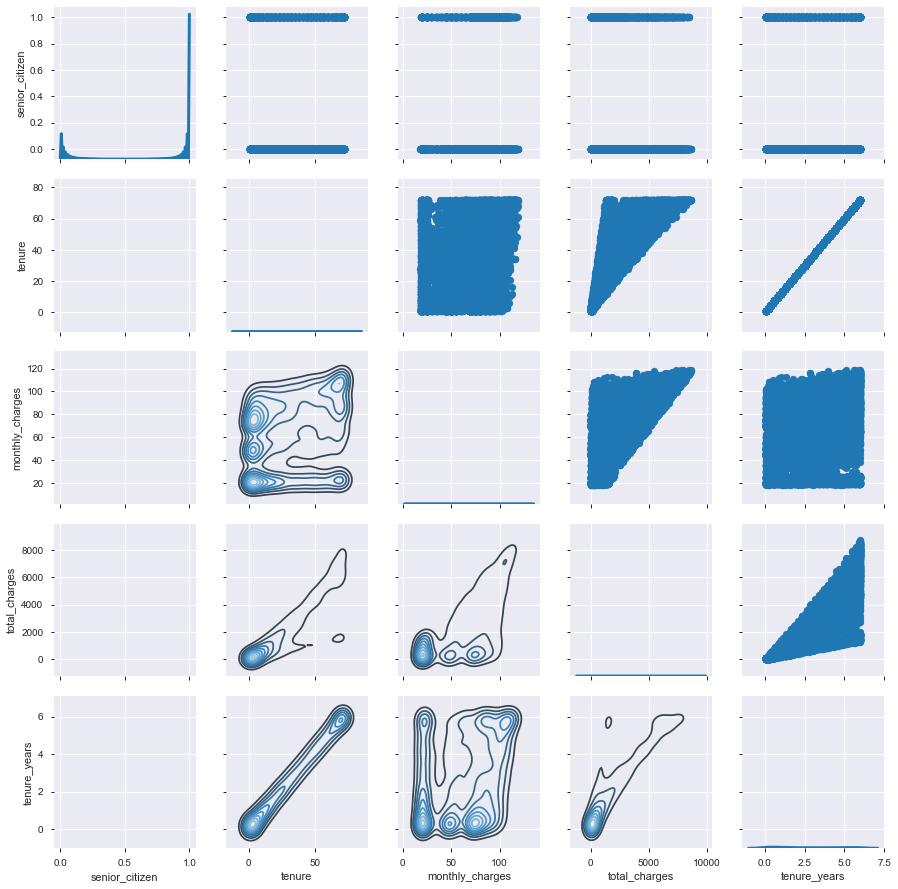

In [107]:
g = sns.PairGrid(df)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, cmap="Blues_d")
g = g.map_diag(sns.kdeplot, lw=3, legend=False)

## Data Preparation

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
df = get_telco()
df["tenure_years"] = [n/12 for n in df.tenure]
df.drop(columns = [ "customer_id","payment_type_id", "internet_service_type_id", "contract_type_id"], inplace=True)
for col in ['gender', 'senior_citizen', 'partner', 'dependents',\
    'phone_service', 'multiple_lines', 'online_security', 'online_backup',\
    'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',\
    'paperless_billing', 'churn','contract_type', 'internet_service_type', 'payment_type']:
    df[col] = df[col].astype('category')
df["total_charges"] = pd.to_numeric(df["total_charges"], errors= "coerce").dropna()
for col in ["tenure_years", "monthly_charges", "tenure"]:
    df[col] = df[col].astype("float")
df.dropna(inplace=True)

## Above:
Created tenure_years, replacing objects astype(category) and astype(float)

In [5]:
df_dict = df.to_dict(orient='records')
from sklearn.feature_extraction import DictVectorizer
dv_df = DictVectorizer(sparse=False)
df_encoded = dv_df.fit_transform(df_dict)
df_machine_model = pd.get_dummies(df, prefix_sep='_', drop_first=True)
df_machine_model.head()

,tenure,monthly_charges,total_charges,tenure_years,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,9.0,59.9,542.40,0.750000,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,9.0,69.4,571.45,0.750000,0,0,0,1,1,0,...,1,1,0,0,0,0,0,1,0,0
2,7.0,48.2,340.35,0.583333,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
3,1.0,25.1,25.10,0.083333,1,1,0,0,0,1,...,0,1,1,0,0,0,0,0,1,0
4,1.0,30.5,30.50,0.083333,0,0,1,1,0,1,...,0,0,1,0,0,0,0,0,0,0


## Above:
Creating df_machine_model to hold machine readable model for regression creation

In [6]:
df_machine_model["pd"] = df_machine_model.partner_Yes + df_machine_model.dependents_Yes
df_machine_model["phone_multiple"] = df_machine_model.phone_service_Yes + df_machine_model.multiple_lines_Yes
df_machine_model.dropna(inplace=True)
for col in ['partner', 'dependents',\
       'phone_service', 'multiple_lines', 'online_security',\
            'online_backup','device_protection', "churn"]:
    df[col] = df[col].replace({"Yes": 1, "No": 0, "No phone service": 2})
df_machine_model.churn_Yes
df["pd"] = df.partner + df.dependents
df["phone_multiple"] = df.phone_service + df.multiple_lines

In [7]:
from sklearn.neighbors import KNeighborsClassifier
train_baseline, test_baseline = train_test_split(df_machine_model, train_size = .75, random_state = 123)
X_train_baseline = train_baseline.drop(columns = "churn_Yes")
X_test_baseline = test_baseline.drop(columns = "churn_Yes")
y_train_baseline = train_baseline.churn_Yes
y_test_baseline = test_baseline.churn_Yes
knn = KNeighborsClassifier(n_neighbors=12, weights='uniform')
knn.fit(X_train_baseline, y_train_baseline)
y_pred_baseline = knn.predict(X_train_baseline)
y_pred_proba_baseline = knn.predict_proba(X_train_baseline)
knn.score(X_train_baseline, y_train_baseline)
knn.score(X_test_baseline, y_test_baseline)

0.7838452787258248

## Above:
BaseLine

In [369]:
train, test = train_test_split(df_machine_model, train_size = .75, random_state = 123)
X_train = train.drop(columns = "churn_Yes")
X_test = test.drop(columns = "churn_Yes")
y_train = train.churn_Yes
y_test = test.churn_Yes

## Prepare summation
There was nan's while converting total_charges, due to the low quantity (~<1% of data), its impact for removal was deemed to be insigificant, and outweighted other considered options. 

Nothing to report regarding new takeaways from the data, several columns were removed due to the data already existing within the data frame. 


#### Could the month in which they signed up influence churn? 

(0, 72)

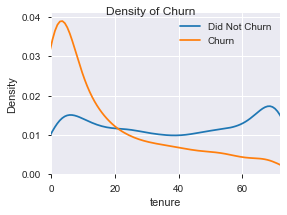

In [371]:
g1 = sns.FacetGrid(df, hue="churn", height = 3, aspect = 1.3)
g1 = g1.map(sns.kdeplot, "tenure")
plt.legend(["Did Not Churn", "Churn"])
g1.fig.suptitle("Density of Churn")
g1.axes[0,0].set_ylabel('Density')
plt.xlim(0,72)

In [ ]:
g1 = sns.FacetGrid(df, hue="churn")
g1 = g1.map(sns.kdeplot, "tenure")
plt.legend(["Did Not Churn", "Churn"])
g3.fig.suptitle("Density of Churn: Gender")
plt.xlim(0,72)

## Above:
Could the month in which they signed up influence churn?
Churn doesn't seem to be driven by the month they were onboarded, more so tenure. 

(0, 72)

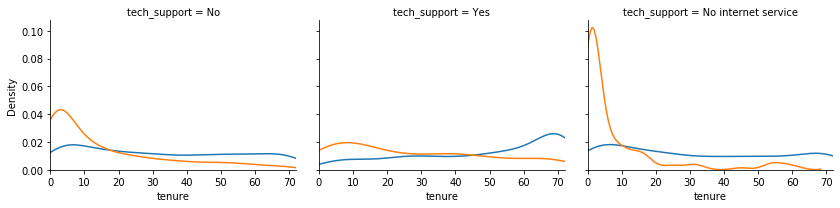

In [325]:
g2 = sns.FacetGrid(df,col = "tech_support", hue="churn", height = 3, aspect = 1.3)
g2 = g2.map(sns.kdeplot, "tenure")
g2.axes[0,0].set_ylabel('Density')
plt.xlim(0,72)

In [42]:
from scipy import stats
x2 = df[df.payment_type == "Mailed check"].tenure
x1 = df[df.payment_type != "Mailed check"].tenure
stats.ttest_ind(x1,x2)

Ttest_indResult(statistic=20.01415344230134, pvalue=1.041062747028532e-86)

(0, 72)

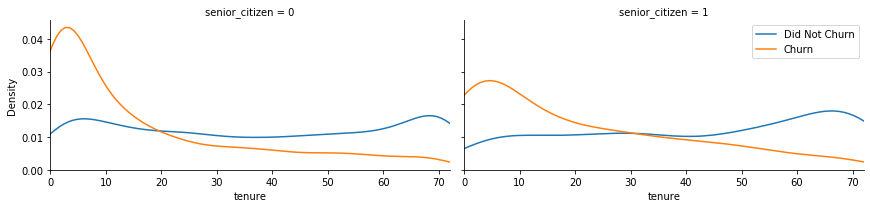

In [324]:
g4 = sns.FacetGrid(df,col = "senior_citizen", hue="churn",height = 3, aspect = 2)
g4 = g4.map(sns.kdeplot, "tenure")
g4.axes[0,0].set_ylabel('Density')
plt.legend(["Did Not Churn", "Churn"])
plt.xlim(0,72)

(0, 72)

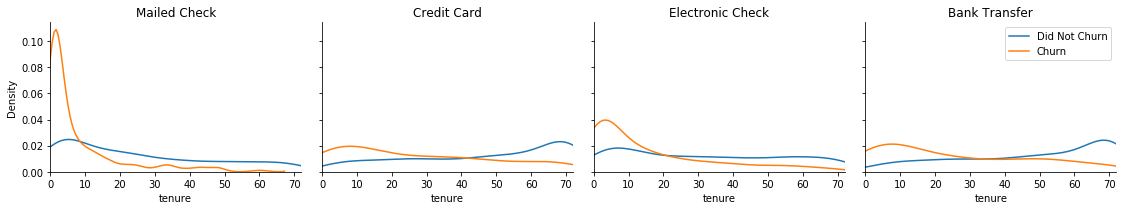

In [320]:
g3 = sns.FacetGrid(df,col = "payment_type", hue="churn",height = 3, aspect = 1.3)
g3 = g3.map(sns.kdeplot, "tenure")
g3.axes[0,0].set_ylabel('Density')
axes = g3.axes.flatten()
axes[0].set_title("Mailed Check")
axes[1].set_title("Credit Card")
axes[2].set_title("Electronic Check")
axes[3].set_title("Bank Transfer")
plt.legend(["Did Not Churn", "Churn"])
plt.xlim(0,72)

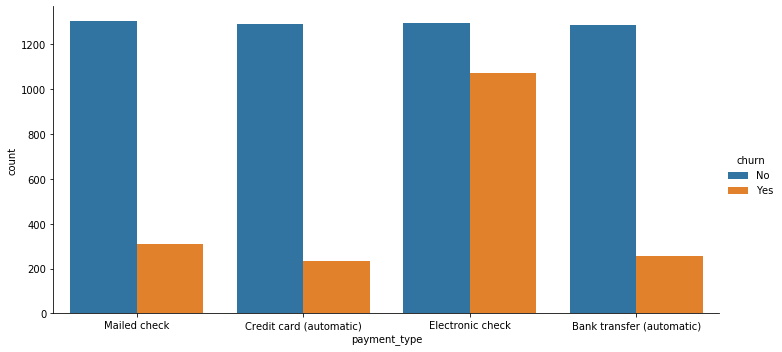

In [334]:
g8 = sns.catplot(x="payment_type",hue="churn", data=df, kind="count", aspect = 2)

### Are there features that indicate a higher propensity to churn?
In short yes, from the surface level analysis I've been able to complete, it does appear that with the features provided, there has been some correlation with some features over others in relation to churn.



Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point?
At this time there is inadiquite information to answer this question. (Data on individal services pricing is required)

In [374]:
df_compare = df
df_compare = df[df.tenure > 12]
df_compare.contract_type.astype(object)
df_compare = df_compare[df_compare.contract_type != "Two year"]
df_compare.contract_type.value_counts()

Month-to-month    1881
One year          1349
Two year             0
Name: contract_type, dtype: int64

Text(0.5, 1, 'One Year')

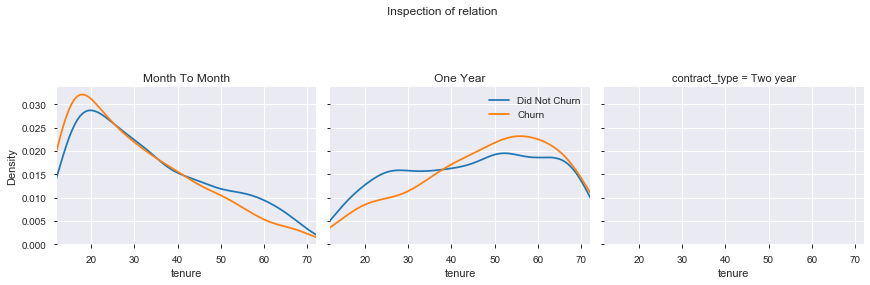

In [398]:
g3 = sns.FacetGrid(df_compare,col = "contract_type", hue="churn",height = 4, aspect = 1)
g3 = g3.map(sns.kdeplot, "tenure")
plt.xlim(12,72)
plt.subplots_adjust(top=.7)
g3.axes[0,0].set_ylabel('Density')
plt.legend(["Did Not Churn", "Churn"])
g3.fig.suptitle("Inspection of relation")
axes = g3.axes.flatten()
axes[0].set_title("Month To Month")
axes[1].set_title("One Year")


In [272]:
df_compare_close = df_compare[df_compare.tenure < 35]

(12, 40)

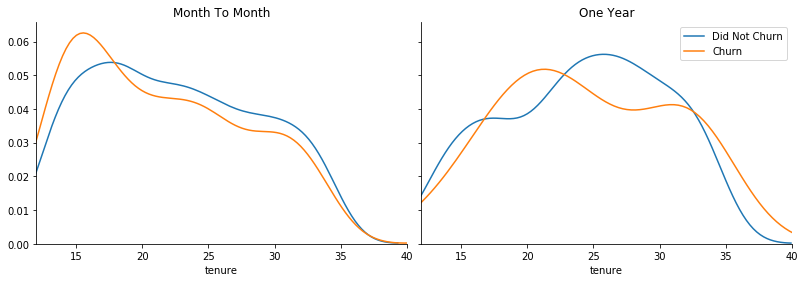

In [300]:
g7 = sns.FacetGrid(df_compare_close,col = "contract_type", hue="churn",height = 4, aspect = 1.4)
g7 = g7.map(sns.kdeplot, "tenure",kernel = "gau")
plt.legend(["Did Not Churn", "Churn"])
axes = g7.axes.flatten()
axes[0].set_title("Month To Month")
axes[1].set_title("One Year")
plt.xlim(12,40)

# NOTE:
Here we can see as soon as the contract ends immidietly the month to month customers churn rate increases, in contrast to the one year, where the churn rate doesn't see an increase till about week 16 or 17. 

In [49]:
mean_churn = df[df.churn == 1].monthly_charges
mean_not_churn = df[df.churn == 0].monthly_charges
print (f"churn = {mean_churn.mean()}, non churn mean is = {mean_not_churn.mean()}")
stats.ttest_ind(mean_churn, mean_not_churn)

churn = 74.44133226324234, non churn mean is = 61.307408483439715


Ttest_indResult(statistic=16.47959313114872, pvalue=6.760843117980302e-60)

## Above:
Is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? 
Yes, those who have churned have been found to have a larger monthly payment, which statistical significance was varified with a t-test. 

In [50]:
df_corr = df_machine_model[["monthly_charges", "internet_service_type_Fiber optic", "internet_service_type_None"]]

## Above:
Null: There is no correlation betweeninternet service and monthly charges. 
Alt: There is a correlation between internet services and monthly charges
The Null has been rejected as internet service type has a relatively strong correlation.

In [51]:
df_corr_2 = df_machine_model[["monthly_charges", "internet_service_type_Fiber optic", "internet_service_type_None", "phone_multiple"]]
df_corr_2

,monthly_charges,internet_service_type_Fiber optic,internet_service_type_None,phone_multiple
0,59.90,0,0,2
1,69.40,0,0,1
2,48.20,0,0,1
3,25.10,0,0,0
4,30.50,0,0,0
5,49.25,0,0,1
6,45.00,0,0,0
7,44.30,0,0,1
8,50.35,0,0,2
9,64.50,0,0,2


In [19]:
df_corr_2.corr()

,monthly_charges,internet_service_type_Fiber optic,internet_service_type_None,phone_multiple
monthly_charges,1.000000,0.787195,-0.763191,0.491412
internet_service_type_Fiber optic,0.787195,1.000000,-0.465736,0.415113
internet_service_type_None,-0.763191,-0.465736,1.000000,-0.082989
phone_multiple,0.491412,0.415113,-0.082989,1.000000


## Above:
Null: There is no correlation between phone/multi lines and monthly charges
Alt: There is correlation between phone/multi lines and monthly charges
Fail to reject null, not strong enough correlation between elements to reject. 

## Above:
Visuals showing correlation was created with Pandas Profiling module, recommended rejecting tenure_years. 
correlation between churn and tenure, senior citizen,  payment type, paperless billing, online security, monthly charges, internet service type, dependents, contract_type are recognized via the Profile. 
Tenure/contract type are related to churn most likley due to customers are locked into a contract. 

(0, 72)

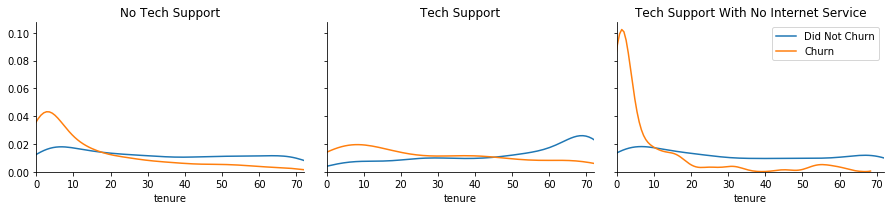

In [302]:
g2 = sns.FacetGrid(df,col = "tech_support", hue="churn",height = 3, aspect = 1.4)
g2 = g2.map(sns.kdeplot, "tenure")
plt.legend(["Did Not Churn", "Churn"])
axes = g2.axes.flatten()
axes[0].set_title("No Tech Support")
axes[1].set_title("Tech Support")
axes[2].set_title("Tech Support With No Internet Service")
plt.xlim(0,72)

In [246]:
df_COR = pd.Series(X_train_final.corrwith(y_train_final, method="spearman").sort_values())

In [244]:
df_COR

tenure                                  -0.369595
tenure_years                            -0.369595
contract_type_Two year                  -0.298729
total_charges                           -0.230705
tech_support_No internet service        -0.229395
device_protection_No internet service   -0.229395
online_backup_No internet service       -0.229395
online_security_No internet service     -0.229395
streaming_movies_No internet service    -0.229395
streaming_tv_No internet service        -0.229395
internet_service_type_None              -0.229395
pd                                      -0.189752
contract_type_One year                  -0.174391
online_security_Yes                     -0.169536
dependents_Yes                          -0.166866
tech_support_Yes                        -0.160428
partner_Yes                             -0.156529
payment_type_Credit card (automatic)    -0.147720
payment_type_Mailed check               -0.085705
online_backup_Yes                       -0.084606


## Above:
All features corr with churn. 

(0, 72)

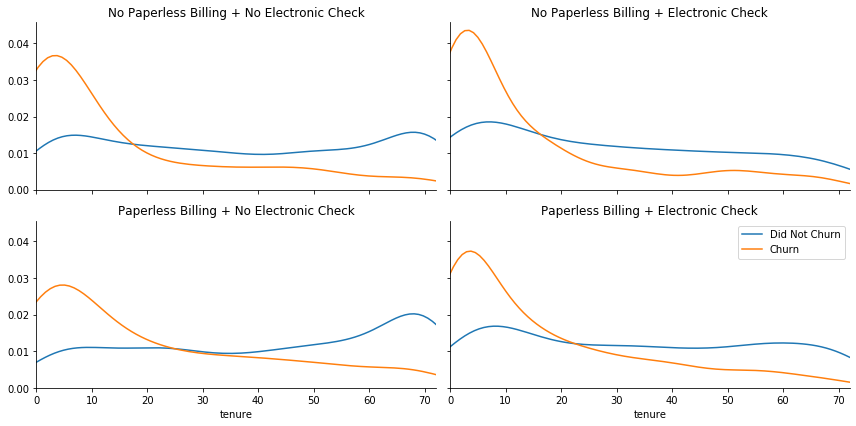

In [305]:
g2 = sns.FacetGrid(df_machine_model,row="paperless_billing_Yes",col = "payment_type_Electronic check", hue="churn_Yes", height = 3, aspect = 2)
g2 = g2.map(sns.kdeplot, "tenure")
plt.legend(["Did Not Churn", "Churn"])
axes = g2.axes.flatten()
axes[0].set_title("No Paperless Billing + No Electronic Check")
axes[1].set_title("No Paperless Billing + Electronic Check")
axes[2].set_title("Paperless Billing + No Electronic Check")
axes[3].set_title("Paperless Billing + Electronic Check")
plt.xlim(0,72)

# Summation
Strong corrolations exist between all variables and churn as found with model who scored .811 on its test, while not all variables appear to contribure to the greater accuracy of this score, it would be recommended and pursued to proceed with feature enginnering in order to render a more precise score. 

In [127]:
#df_machine_final = df_machine_model.drop(columns=["gender_Male", "total_charges", "partner_Yes", "tenure_years", "phone_service_Yes", "multiple_lines_No phone service","device_protection_Yes","streaming_movies_Yes","streaming_movies_No internet service","streaming_tv_Yes", "multiple_lines_Yes", "pd", "streaming_tv_No internet service", "tech_support_No internet service","online_backup_Yes","tech_support_Yes","device_protection_No internet service","phone_multiple"])
df_machine_final = df_machine_model

In [210]:
train_final, test_final = train_test_split(df_machine_final, train_size = .75, random_state = 123)
X_train_final = train_final.drop(columns = "churn_Yes")
X_test_final = test_final.drop(columns = "churn_Yes")
y_train_final = train_final.churn_Yes
y_test_final = test_final.churn_Yes

In [22]:
def optimal_number_of_features(X_train, y_train, X_test, y_test):
    number_of_attributes = X_train.shape[1]
    number_of_features_list=np.arange(1,number_of_attributes)
    high_score=0
    number_of_features=0           
    score_list =[]
    for n in range(len(number_of_features_list)):
        model = LinearRegression()
        rfe = RFE(model,number_of_features_list[n])
        X_train_rfe = rfe.fit_transform(X_train,y_train)
        X_test_rfe = rfe.transform(X_test)
        model.fit(X_train_rfe,y_train)
        score = model.score(X_test_rfe,y_test)
        score_list.append(score)
        if(score>high_score):
            high_score = score
            number_of_features = number_of_features_list[n]
    return number_of_features, high_score

def optimal_features(X_train, y_train, number_of_features):
    cols = list(X_train.columns)
    model = LinearRegression()
    rfe = RFE(model, number_of_features)
    X_rfe = rfe.fit_transform(X_train,y_train)  
    model.fit(X_rfe,y_train)
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    return selected_features_rfe

def optimal_dataframe(X_train, X_test, selected_features_rfe):
    X_train_df = X_train[selected_features_rfe]
    X_test_df = X_test[selected_features_rfe]
    return X_train_df, X_test_df



def select_features():
    n_features, high_score = optimal_number_of_features(X_train,y_train,X_test,y_test)
    selected_features = optimal_features(X_train,y_train,n_features)
    X_train_sf, X_test_sf = optimal_dataframe(X_train, X_test, selected_features)
    return X_train_sf, X_test_sf


In [23]:
n_features, high_score = optimal_number_of_features(X_train_final, y_train_final, X_test_final, y_test_final)

In [24]:
selected_features = optimal_features(X_train_final,y_train_final, 30)

In [25]:
X_train_sf, X_test_sf = optimal_dataframe(X_train_final, y_train_final, selected_features)

In [214]:
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train_final, y_train_baseline)
y_pred_baseline = knn.predict(X_train_final)
y_pred_proba_baseline = knn.predict_proba(X_train_final)
knn.score(X_test_final, y_test_final)

0.7838452787258248

In [384]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
df_2 = get_telco()
df_2 = df.set_index('customer_id')

In [385]:
train_2, test_2 = train_test_split(df_2, train_size = .75, random_state = 123)
X_train_2 = train_2.drop(columns = "churn")
X_test_2 = test_2.drop(columns = "churn")
y_train_2 = train_2.churn
y_test_2 = test_2.churn

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_features = train_2.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_2.select_dtypes(include=['object']).drop(['churn'], axis=1).columns
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC, NuSVR
classifiers = [
    NuSVC(probability=True, random_state = 123)]
for classifier in classifiers:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', classifier)])
    pipe.fit(X_train_2, y_train_2) 
    print(classifier)
    print("model score: %.3f" % pipe.score(X_train_2, y_train_2))


NuSVC(cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, probability=True, random_state=123,
      shrinking=True, tol=0.001, verbose=False)
model score: 0.801


SVM explaination
https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989

In [346]:
Nu = Pipeline(steps=[('preprocessor', preprocessor),('classifier', NuSVC(probability=True, random_state = 123))])
Nu.fit(X_train_2, y_train_2)
y_pred = Nu.predict(X_test_2)

In [347]:
y_pred_proba = Nu.predict_proba(X_test_2)

In [110]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test_2, y_pred))

[[1177  107]
 [ 222  255]]


In [111]:
print(classification_report(y_test_2, y_pred))

              precision    recall  f1-score   support

          No       0.84      0.92      0.88      1284
         Yes       0.70      0.53      0.61       477

    accuracy                           0.81      1761
   macro avg       0.77      0.73      0.74      1761
weighted avg       0.80      0.81      0.80      1761



In [129]:
from sklearn.metrics import fbeta_score, make_scorer,precision_score,recall_score,accuracy_score
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [130]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
def grid_search_wrapper(refit_score='precision_score'):
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_final.values, y_train_final.values)
    y_pred = grid_search.predict(X_test_final.values)
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test_final, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [133]:
grid_search_clf = grid_search_wrapper(refit_score="recall_score")

Best params for recall_score
{'max_depth': 15, 'max_features': 10, 'min_samples_split': 3, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      1151       135
pos       223       249


In [134]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
5,0.774,0.212,0.775,3,3,10,300
3,0.765,0.224,0.776,3,3,5,300
2,0.762,0.223,0.776,3,3,5,100
4,0.751,0.226,0.775,3,3,10,100
1,0.749,0.224,0.775,3,3,3,300


In [136]:
grid_search_clf

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fra...
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 15, 25],
                         'max_features': [3, 5, 10, 20],
                         'min_samples_split': [3, 5, 10],
                         'n_estim

In [224]:
rf = RandomForestClassifier(max_depth= 20, max_features= 10, min_samples_split=3, n_estimators= 300)


In [225]:
rf.fit(X_train_final, y_train_final)
y_pred = rf.predict(X_train_final)
y_pred_proba = rf.predict_proba(X_train_final)
rf.score(X_train_final, y_train)

0.99677664012135

In [226]:
confusion_matrix(y_train, y_pred)

array([[3871,    6],
       [  11, 1386]])

In [227]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3877
           1       1.00      0.99      0.99      1397

    accuracy                           1.00      5274
   macro avg       1.00      1.00      1.00      5274
weighted avg       1.00      1.00      1.00      5274



In [228]:
rf.score(X_test_final, y_test)

0.7918088737201365

In [230]:
y_pred_test = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test_final)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1286
           1       0.64      0.52      0.57       472

    accuracy                           0.79      1758
   macro avg       0.74      0.70      0.72      1758
weighted avg       0.78      0.79      0.78      1758



## Above:
Attempted secondary model, attempt failed, score did not exceed final_model. 